# Problem Statement

Quantium has had a data partnership with a large supermarket brand for the last few years who provide transactional and customer data. Supermarket will regularly change their store layouts, product selections, prices and promotions. This is to satisfy their customer’s changing needs and preferences, keep up with the increasing competition in the market or to capitalise on new opportunities. The Quantium analytics team are engaged in these processes to evaluate and analyse the performance of change and recommend whether it has been successful. 

# Objectives
* Look for inconsistencies, missing data across the data set, outliers, correctly identified category items, numeric data across all tables. 
* Explore the data, create charts and graphs as well as noting any interesting trends and/or insights found.
* Define recommendation from the insights, determine which segments we should be targeting.
* Perform apriori algorithm to gain insight into the structured relationships between different products.

In [1]:
# Import libraries
import warnings
warnings.filterwarnings('ignore')
import xlrd 
from statistics import stdev
import scipy.stats
from statsmodels.stats.weightstats import ztest
from scipy import stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
import seaborn as sns

# for NLP reviews of the prod_name
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import re, nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
from nltk.stem.wordnet import WordNetLemmatizer

from mlxtend.frequent_patterns import apriori, association_rules
from efficient_apriori import apriori # for association analysis

In [2]:
# Load datasets
trx_data = pd.read_excel(r"C:\Users\NG POOI LING\Desktop\Forage D.Analytics\Quantium\QVI_transaction_data.xlsx")
pur_bhv = pd.read_csv(r"C:\Users\NG POOI LING\Desktop\Forage D.Analytics\Quantium\QVI_purchase_behaviour.csv")

In [3]:
trx_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264836 entries, 0 to 264835
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   DATE            264836 non-null  int64  
 1   STORE_NBR       264836 non-null  int64  
 2   LYLTY_CARD_NBR  264836 non-null  int64  
 3   TXN_ID          264836 non-null  int64  
 4   PROD_NBR        264836 non-null  int64  
 5   PROD_NAME       264836 non-null  object 
 6   PROD_QTY        264836 non-null  int64  
 7   TOT_SALES       264836 non-null  float64
dtypes: float64(1), int64(6), object(1)
memory usage: 16.2+ MB


`store_nbr`, `lylty_card_nbr`, `txn_id` & `prod_nbr` do not convey much information, but acting as identifier for the store, customer, transaction, and product respectively.

In [4]:
# Convert excel serial date to datetime
date_formatted = []  
for i in trx_data['DATE']:
    datetime_date = xlrd.xldate_as_datetime(i, 0)
    date_object = datetime_date.date()
    date_formatted.append(date_object)  
trx_data['date_formatted'] = date_formatted
trx_data = trx_data.drop('DATE',axis=1)

# rearrange the sequence of columns
cols = trx_data.columns.to_list()
cols = cols[-1:] + cols[:-1]
trx_data = trx_data[cols]
print('Earlist date: ',trx_data['date_formatted'].min())
print('Recent date: ',trx_data['date_formatted'].max())
print('Missing Data:', pd.date_range(start=trx_data['date_formatted'].min(), 
                                     end=trx_data['date_formatted'].max()).difference(trx_data['date_formatted']))

Earlist date:  2018-07-01
Recent date:  2019-06-30
Missing Data: DatetimeIndex(['2018-12-25'], dtype='datetime64[ns]', freq=None)


In [5]:
trx_data[trx_data.select_dtypes(include=[int,float]).columns.to_list()].nunique()

STORE_NBR            272
LYLTY_CARD_NBR     72637
TXN_ID            263127
PROD_NBR             114
PROD_QTY               6
TOT_SALES            112
dtype: int64

In [6]:
trx_data['TXN_ID'].value_counts().head(5)

108462    3
1162      3
211119    3
228741    3
222775    3
Name: TXN_ID, dtype: int64

In [7]:
# Look for duplicated TXN_ID
trx_data[trx_data['TXN_ID'] == 211119]

date_formatted  STORE_NBR  LYLTY_CARD_NBR  TXN_ID  PROD_NBR  \
146941     2019-05-12        212          212113  211119       108   
146942     2019-05-12        212          212113  211119       107   
146943     2019-05-12        212          212113  211119        17   

                                       PROD_NAME  PROD_QTY  TOT_SALES  
146941  Kettle Tortilla ChpsHny&Jlpno Chili 150g         2        9.2  
146942  Smiths Crinkle Cut  French OnionDip 150g         2        5.2  
146943        Kettle Sensations   BBQ&Maple 150g         2        9.2

TXN_ID is repeated because there can be sales of chips with different brands in a single transaction.

In [8]:
pur_bhv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72637 entries, 0 to 72636
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   LYLTY_CARD_NBR    72637 non-null  int64 
 1   LIFESTAGE         72637 non-null  object
 2   PREMIUM_CUSTOMER  72637 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


From the information above, we can conclude that both datasets have no missing value as their non-null count is equal to their number of entries. Besides, these 2 datasets could be merged based on the common column called 'LYLTY_CARD_NBR'.

In [9]:
comp_df = trx_data.merge(pur_bhv, on='LYLTY_CARD_NBR', how='left')
comp_df.columns = comp_df.columns.str.lower() # change the column names to lower case
# comp_df = comp_df.set_index(comp_df["date_formatted"]) # set the date as the index of dataframe

In [10]:
comp_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 264836 entries, 0 to 264835
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   date_formatted    264836 non-null  object 
 1   store_nbr         264836 non-null  int64  
 2   lylty_card_nbr    264836 non-null  int64  
 3   txn_id            264836 non-null  int64  
 4   prod_nbr          264836 non-null  int64  
 5   prod_name         264836 non-null  object 
 6   prod_qty          264836 non-null  int64  
 7   tot_sales         264836 non-null  float64
 8   lifestage         264836 non-null  object 
 9   premium_customer  264836 non-null  object 
dtypes: float64(1), int64(5), object(4)
memory usage: 22.2+ MB


In [11]:
comp_df.describe(include=[int,float,object])

date_formatted     store_nbr  lylty_card_nbr        txn_id  \
count          264836  264836.00000    2.648360e+05  2.648360e+05   
unique            364           NaN             NaN           NaN   
top        2018-12-24           NaN             NaN           NaN   
freq              939           NaN             NaN           NaN   
mean              NaN     135.08011    1.355495e+05  1.351583e+05   
std               NaN      76.78418    8.057998e+04  7.813303e+04   
min               NaN       1.00000    1.000000e+03  1.000000e+00   
25%               NaN      70.00000    7.002100e+04  6.760150e+04   
50%               NaN     130.00000    1.303575e+05  1.351375e+05   
75%               NaN     203.00000    2.030942e+05  2.027012e+05   
max               NaN     272.00000    2.373711e+06  2.415841e+06   

             prod_nbr                               prod_name       prod_qty  \
count   264836.000000                                  264836  264836.000000   
unique            NaN                                     114            NaN   
top               NaN  Kettle Mozzarella   Basil & Pesto 175g            NaN   
freq              NaN                                    3304            NaN   
mean        56.583157                                     NaN       1.907309   
std         32.826638                                     NaN       0.643654   
min          1.000000                                     NaN       1.000000   
25%         28.000000                                     NaN       2.000000   
50%         56.000000                                     NaN       2.000000   
75%         85.000000                                     NaN       2.000000   
max        114.000000                                     NaN     200.000000   

            tot_sales              lifestage premium_customer  
count   264836.000000                 264836           264836  
unique            NaN                      7                3  
top               NaN  OLDER SINGLES/COUPLES       Mainstream  
freq              NaN                  54479           101988  
mean         7.304200                    NaN              NaN  
std          3.083226                    NaN              NaN  
min          1.500000                    NaN              NaN  
25%          5.400000                    NaN              NaN  
50%          7.400000                    NaN              NaN  
75%          9.200000                    NaN              NaN  
max        650.000000                    NaN              NaN

# Data Processing & Wrangling 

In [12]:
initial=[]
for i in comp_df['prod_name'].unique():
    initial.append(i[0])
initial.sort()
np.unique(initial) 

array(['B', 'C', 'D', 'F', 'G', 'I', 'K', 'N', 'O', 'P', 'R', 'S', 'T',
       'W'], dtype='<U1')

In [13]:
print(len(comp_df[comp_df['prod_name'].str.startswith('C')==True]['prod_name']))
comp_df[comp_df['prod_name'].str.startswith('C')==True]['prod_name'].value_counts() # 'Cobs Popd', 'Cheezels', 'CCs', 'Cheetos'

21774


Cobs Popd Swt/Chlli &Sr/Cream Chips 110g    3269
Cobs Popd Sea Salt  Chips 110g              3265
Cobs Popd Sour Crm  &Chives Chips 110g      3159
Cheezels Cheese 330g                        3149
CCs Tasty Cheese    175g                    1539
CCs Original 175g                           1514
CCs Nacho Cheese    175g                    1498
Cheetos Chs & Bacon Balls 190g              1479
Cheezels Cheese Box 125g                    1454
Cheetos Puffs 165g                          1448
Name: prod_name, dtype: int64

In [14]:
# standardize the brand name and remove abbreviations
comp_df['prod_name'] = comp_df['prod_name'].replace({'Cobs Popd Swt/Chlli &Sr/Cream Chips 110g':'Cobs Popd Sweet Chlli & Sour Cream Chips 110g',
                                                     'Cobs Popd Sea Salt  Chips 110g':'Cobs Popd Sea Salt Chips 110g',
                                                     'Cobs Popd Sour Crm  &Chives Chips 110g':'Cobs Popd Sour Cream & Chives Chips 110g',
                                                     'CCs Tasty Cheese    175g':'CCs Tasty Cheese 175g',
                                                     'CCs Nacho Cheese    175g':'CCs Nacho Cheese 175g',
                                                     'Cheetos Chs & Bacon Balls 190g':'Cheetos Cheese & Bacon Balls 190g'})

In [15]:
print(len(comp_df[comp_df['prod_name'].str.startswith('D')==True]['prod_name']))
comp_df[comp_df['prod_name'].str.startswith('D')==True]['prod_name'].value_counts() # Doritos

28147


Doritos Corn Chips  Cheese Supreme 170g    3217
Doritos Corn Chip Mexican Jalapeno 150g    3204
Dorito Corn Chp     Supreme 380g           3185
Doritos Corn Chip Southern Chicken 150g    3172
Doritos Corn Chips  Nacho Cheese 170g      3160
Doritos Corn Chips  Original 170g          3121
Doritos Mexicana    170g                   3115
Doritos Cheese      Supreme 330g           3052
Doritos Salsa Mild  300g                   1472
Doritos Salsa       Medium 300g            1449
Name: prod_name, dtype: int64

In [16]:
# standardize the brand name and remove abbreviations
comp_df['prod_name'] = comp_df['prod_name'].replace({'Doritos Corn Chips  Cheese Supreme 170g':'Doritos Corn Chips Cheese Supreme 170g',
                                                     'Dorito Corn Chp     Supreme 380g':'Doritos Corn Chip Supreme 380g',
                                                     'Doritos Corn Chips  Nacho Cheese 170g':'Doritos Corn Chips Nacho Cheese 170g',
                                                     'Doritos Corn Chips  Original 170g':'Doritos Corn Chips Original 170g',
                                                     'Doritos Mexicana    170g':'Doritos Mexicana 170g',
                                                     'Doritos Cheese      Supreme 330g':'Doritos Cheese Supreme 330g',
                                                     'Doritos Salsa Mild  300g':'Doritos Salsa Mild 300g',
                                                     'Doritos Salsa       Medium 300g':'Doritos Salsa Medium 300g'})

In [17]:
print(len(comp_df[comp_df['prod_name'].str.startswith('G')==True]['prod_name']))
comp_df[comp_df['prod_name'].str.startswith('G')==True]['prod_name'].value_counts() # Grain Waves

7740


Grain Waves         Sweet Chilli 210g    3167
Grain Waves Sour    Cream&Chives 210G    3105
GrnWves Plus Btroot & Chilli Jam 180g    1468
Name: prod_name, dtype: int64

In [18]:
# standardize the brand name and remove abbreviations
# Grain Waves are under the brand of Sunbites  
comp_df['prod_name'] = comp_df['prod_name'].replace({'GrnWves Plus Btroot & Chilli Jam 180g':'Sunbites Grain Waves Plus Beetroot & Chilli Jam 180g',
                                                     'Grain Waves Sour    Cream&Chives 210G':'Sunbites Grain Waves Sour Cream & Chives 210g',
                                                     'Grain Waves         Sweet Chilli 210g':'Sunbites Grain Waves Sweet Chilli 210g'})

In [19]:
print(len(comp_df[comp_df['prod_name'].str.startswith('I')==True]['prod_name']))
comp_df[comp_df['prod_name'].str.startswith('I')==True]['prod_name'].value_counts() # Infuzions 

14201


Infuzions Thai SweetChili PotatoMix 110g    3242
Infuzions BBQ Rib   Prawn Crackers 110g     3174
Infzns Crn Crnchers Tangy Gcamole 110g      3144
Infuzions SourCream&Herbs Veg Strws 110g    3134
Infuzions Mango     Chutny Papadums 70g     1507
Name: prod_name, dtype: int64

In [20]:
# standardize the brand name and remove abbreviations
comp_df['prod_name'] = comp_df['prod_name'].replace({'Infuzions Thai SweetChili PotatoMix 110g':'Infuzions Thai Sweet Chili Potato Mix 110g',
                                                     'Infuzions BBQ Rib   Prawn Crackers 110g':'Infuzions BBQ Rib Prawn Crackers 110g',
                                                     'Infzns Crn Crnchers Tangy Gcamole 110g':'Infuzions Corn Crunchers Tangy Guacamole 110g',
                                                     'Infuzions SourCream&Herbs Veg Strws 110g':'Infuzions Sour Cream & Herbs Veggie Straws 110g',
                                                     'Infuzions Mango     Chutny Papadums 70g':'Infuzions Mango Chutney Papadums 70g'})

In [21]:
print(len(comp_df[comp_df['prod_name'].str.startswith('K')==True]['prod_name']))
comp_df[comp_df['prod_name'].str.startswith('K')==True]['prod_name'].value_counts() # Kettle 

41288


Kettle Mozzarella   Basil & Pesto 175g      3304
Kettle Tortilla ChpsHny&Jlpno Chili 150g    3296
Kettle 135g Swt Pot Sea Salt                3257
Kettle Sensations   Camembert & Fig 150g    3219
Kettle Sweet Chilli And Sour Cream 175g     3200
Kettle Sea Salt     And Vinegar 175g        3173
Kettle Original 175g                        3159
Kettle Honey Soy    Chicken 175g            3148
Kettle Tortilla ChpsBtroot&Ricotta 150g     3146
Kettle Tortilla ChpsFeta&Garlic 150g        3138
Kettle Sensations   Siracha Lime 150g       3127
Kettle Sensations   BBQ&Maple 150g          3083
Kettle Chilli 175g                          3038
Name: prod_name, dtype: int64

In [22]:
# standardize the brand name and remove abbreviations
comp_df['prod_name'] = comp_df['prod_name'].replace({'Kettle Mozzarella   Basil & Pesto 175G':'Kettle Mozzarella Basil & Pesto 175g',
                                                     'Kettle Tortilla ChpsHny&Jlpno Chili 150g':'Kettle Tortilla Chips Honey & Jalapeno Chili 150g',
                                                     'Kettle 135g Swt Pot Sea Salt':'Kettle Sweet Potato Sea Salt 135g',
                                                     'Kettle Sensations   Camembert & Fig 150G':'Kettle Sensations Camembert & Fig 150g',
                                                     'Kettle Sea Salt     And Vinegar 175G':'Kettle Sea Salt And Vinegar 175g',
                                                     'Kettle Honey Soy    Chicken 175G':'Kettle Honey Soy Chicken 175g',
                                                     'Kettle Tortilla ChpsBtroot&Ricotta 150g':'Kettle Tortilla Chips Beetroot & Ricotta 150g',
                                                     'Kettle Tortilla ChpsFeta&Garlic 150g':'Kettle Tortilla Chips Feta & Garlic 150g',
                                                     'Kettle Sensations   Siracha Lime 150G':'Kettle Sensations Siracha Lime 150g',
                                                     'Kettle Sensations   BBQ&Maple 150g':'Kettle Sensations BBQ & Maple 150g'})

In [23]:
print(len(comp_df[comp_df['prod_name'].str.startswith('N')==True]['prod_name']))
comp_df[comp_df['prod_name'].str.startswith('N')==True]['prod_name'].value_counts() # Natural ChipCo 

7469


Natural Chip Co     Tmato Hrb&Spce 175g    1572
Natural ChipCo Sea  Salt & Vinegr 175g     1550
Natural Chip        Compny SeaSalt175g     1468
Natural ChipCo      Hony Soy Chckn175g     1460
NCC Sour Cream &    Garden Chives 175g     1419
Name: prod_name, dtype: int64

In [24]:
# standardize the brand name and remove abbreviations
comp_df['prod_name'] = comp_df['prod_name'].replace({'Natural Chip Co     Tmato Hrb&Spce 175g':'Natural ChipCo Tomato Herb & Spices 175g',
                                                     'Natural ChipCo Sea  Salt & Vinegr 175g':'Natural ChipCo Sea Salt & Vinegar 175g',
                                                     'Natural Chip        Compny SeaSalt175g':'Natural ChipCo Sea Salt 175g',
                                                     'Natural ChipCo      Hony Soy Chckn175g':'Natural ChipCo Honey Soy Chicken 175g',
                                                     'NCC Sour Cream &    Garden Chives 175g':'Natural ChipCo Sour Cream & Garden Chives 175g'})

In [25]:
print(len(comp_df[comp_df['prod_name'].str.startswith('O')==True]['prod_name']))
comp_df[comp_df['prod_name'].str.startswith('O')==True]['prod_name'].value_counts() # Old El Paso Salsa

9324


Old El Paso Salsa   Dip Chnky Tom Ht300g    3125
Old El Paso Salsa   Dip Tomato Med 300g     3114
Old El Paso Salsa   Dip Tomato Mild 300g    3085
Name: prod_name, dtype: int64

In [26]:
# standardize the brand name and remove abbreviations
comp_df['prod_name'] = comp_df['prod_name'].replace({'Old El Paso Salsa   Dip Chnky Tom Ht300g':'Old El Paso Salsa Dip Chunky Tomato Hot 300g',
                                                     'Old El Paso Salsa   Dip Tomato Med 300g':'Old El Paso Salsa Dip Tomato Medium 300g',
                                                     'Old El Paso Salsa   Dip Tomato Mild 300g': 'Old El Paso Salsa Dip Tomato Mild 300g'})

In [27]:
print(len(comp_df[comp_df['prod_name'].str.startswith('P')==True]['prod_name']))
comp_df[comp_df['prod_name'].str.startswith('P')==True]['prod_name'].value_counts() # Pringles

25102


Pringles Barbeque   134g               3210
Pringles Sweet&Spcy BBQ 134g           3177
Pringles SourCream  Onion 134g         3162
Pringles Original   Crisps 134g        3157
Pringles Mystery    Flavour 134g       3114
Pringles Chicken    Salt Crips 134g    3104
Pringles Slt Vingar 134g               3095
Pringles Sthrn FriedChicken 134g       3083
Name: prod_name, dtype: int64

In [28]:
# standardize the brand name and remove abbreviations
comp_df['prod_name'] = comp_df['prod_name'].replace({'Pringles Barbeque   134g':'Pringles BBQ 134g',
                                                     'Pringles Sweet&Spcy BBQ 134g':'Pringles Sweet & Spicy BBQ 134g',
                                                     'Pringles SourCream  Onion 134g':'Pringles Sour Cream Onion 134g',
                                                     'Pringles Original   Crisps 134g':'Pringles Original Crisps 134g',
                                                     'Pringles Mystery    Flavour 134g':'Pringles Mystery Flavour 134g',
                                                     'Pringles Chicken    Salt Crips 134g':'Pringles Chicken Salt Crips 134g',
                                                     'Pringles Slt Vingar 134g': 'Pringles Salt Vingar 134g',
                                                     'Pringles Sthrn FriedChicken 134g':'Pringles Southern Fried Chicken 134g'})

In [29]:
print(len(comp_df[comp_df['prod_name'].str.startswith('R')==True]['prod_name']))
comp_df[comp_df['prod_name'].str.startswith('R')==True]['prod_name'].value_counts() # RRD

17779


RRD SR Slow Rst     Pork Belly 150g         1526
RRD Sweet Chilli &  Sour Cream 165g         1516
RRD Honey Soy       Chicken 165g            1513
RRD Chilli&         Coconut 150g            1506
Red Rock Deli Sp    Salt & Truffle 150G     1498
Red Rock Deli Thai  Chilli&Lime 150g        1495
RRD Salt & Vinegar  165g                    1474
RRD Lime & Pepper   165g                    1473
Red Rock Deli SR    Salsa & Mzzrlla 150g    1458
RRD Steak &         Chimuchurri 150g        1455
Red Rock Deli Chikn&Garlic Aioli 150g       1434
RRD Pc Sea Salt     165g                    1431
Name: prod_name, dtype: int64

In [30]:
# standardize the brand name and remove abbreviations
comp_df['prod_name'] = comp_df['prod_name'].replace({'RRD SR Slow Rst     Pork Belly':'RRD Slow Roast Pork Belly',
                                                     'RRD Sweet Chilli &  Sour Cream 165g':'RRD Sweet Chilli & Sour Cream 165g',
                                                     'RRD Honey Soy       Chicken 165g':'RRD Honey Soy Chicken 165g',
                                                     'RRD Chilli&         Coconut 150g':'RRD Chilli & Coconut 150g',                                                     
                                                     'Red Rock Deli Sp    Salt & Truffle 150G':'RRD Chips Salt & Truffle 150g',
                                                     'Red Rock Deli Thai  Chilli&Lime 150g':'RRD Thai Chilli & Lime 150g',
                                                     'RRD Salt & Vinegar  165g':'RRD Salt & Vinegar 165g',
                                                     'RRD Lime & Pepper   165g':'RRD Lime & Pepper 165g',
                                                     'Red Rock Deli SR    Salsa & Mzzrlla 150g':'RRD Salsa & Mozzarella 150g',
                                                     'RRD Steak &         Chimuchurri 150g':'RRD Steak & Chimuchurri 150g',
                                                     'Red Rock Deli Chikn&Garlic Aioli 150g':'RRD Chicken & Garlic Aioli 150g',
                                                     'RRD Pc Sea Salt     165g':'RRD Potato Chip Sea Salt 165g'})

In [31]:
print(len(comp_df[comp_df['prod_name'].str.startswith('S')==True]['prod_name']))
comp_df[comp_df['prod_name'].str.startswith('S')==True]['prod_name'].value_counts() # Smiths, Sunbites 

42571


Smiths Crnkle Chip  Orgnl Big Bag 380g                  3233
Smiths Crinkle Chips Salt & Vinegar 330g                3197
Sunbites Grain Waves Sweet Chilli 210g                  3167
Smiths Crinkle      Original 330g                       3142
Sunbites Grain Waves Sour Cream & Chives 210g           3105
Smiths Chip Thinly  Cut Original 175g                   1614
Snbts Whlgrn Crisps Cheddr&Mstrd 90g                    1576
Smiths Thinly Cut   Roast Chicken 175g                  1519
Smith Crinkle Cut   Mac N Cheese 150g                   1512
Smiths Crinkle Cut  Snag&Sauce 150g                     1503
Smiths Crinkle Cut  Chips Barbecue 170g                 1489
Smiths Crinkle Cut  Chips Chicken 170g                  1484
Smiths Crinkle Cut  Chips Chs&Onion170g                 1481
Smiths Chip Thinly  S/Cream&Onion 175g                  1473
Smiths Crinkle Cut  Tomato Salsa 150g                   1470
Sunbites Grain Waves Plus Beetroot & Chilli Jam 180g    1468
Smiths Crinkle Cut  Chip

In [32]:
# standardize the brand name and remove abbreviations
comp_df['prod_name'] = comp_df['prod_name'].replace({'Smiths Crnkle Chip  Orgnl Big Bag 380g':'Smiths Crinkle Chip Original Big Bag 380g',
                                                     'Smiths Crinkle      Original 330g':'Smiths Crinkle Original 330g',
                                                     'Smiths Chip Thinly  Cut Original 175g':'Smiths Chip Thinly Cut Original 175g',
                                                     'Snbts Whlgrn Crisps Cheddr&Mstrd 90g':'Sunbites Wholegrain Crisps Cheddar & Mustard 90g',
                                                     'Smiths Thinly Cut   Roast Chicken 175g':'Smiths Thinly Cut Roast Chicken 175g',
                                                     'Smith Crinkle Cut   Mac N Cheese 150g':'Smiths Crinkle Cut Mac N Cheese 150g',
                                                     'Smiths Crinkle Cut  Snag&Sauce 150g':'Smiths Crinkle Cut Snag & Sauce 150g',
                                                     'Smiths Crinkle Cut  Chips Barbecue 170g':'Smiths Crinkle Cut Chips Barbecue 170g',
                                                     'Smiths Crinkle Cut  Chips Chicken 170g':'Smiths Crinkle Cut Chips Chicken 170g',
                                                     'Smiths Crinkle Cut  Chips Chs&Onion170g':'Smiths Crinkle Cut  Chips Cheese & Onion 170g',
                                                     'Smiths Chip Thinly  S/Cream&Onion 175g':'Smiths Chip Thinly Sour Cream & Onion 175g',
                                                     'Smiths Crinkle Cut  Tomato Salsa 150g':'Smiths Crinkle Cut Tomato Salsa 150g',
                                                     'Smiths Crinkle Cut  Chips Original 170g':'Smiths Crinkle Cut Chips Original 170g',
                                                     'Smiths Thinly       Swt Chli&S/Cream175G':'Smiths Thinly Sweet Chilli & Sour Cream 175g',
                                                     'Smiths Crinkle Cut  Salt & Vinegar 170g':'Smiths Crinkle Cut Salt & Vinegar 170g',
                                                     'Smith Crinkle Cut   Bolognese 150g':'Smiths Crinkle Cut Bolognese 150g',
                                                     'Smiths Chip Thinly  CutSalt/Vinegr175g':'Smiths Chip Thinly Cut Salt Vinegar 175g',
                                                     'Smiths Crinkle Cut  French OnionDip 150g':'Smiths Crinkle Cut French Onion Dip 150g',
                                                     'Sunbites Whlegrn    Crisps Frch/Onin 90g':'Sunbites Wholegrain Crisps French Onion 90g'})        

In [33]:
print(len(comp_df[comp_df['prod_name'].str.startswith('T')==True]['prod_name']))
comp_df[comp_df['prod_name'].str.startswith('T')==True]['prod_name'].value_counts() # Tyrrells, Tostitos, Thins, Twisties

39442


Tyrrells Crisps     Ched & Chives 165g     3268
Tostitos Splash Of  Lime 175g              3252
Thins Potato Chips  Hot & Spicy 175g       3229
Thins Chips Light&  Tangy 175g             3188
Tyrrells Crisps     Lightly Salted 165g    3174
Twisties Chicken270g                       3170
Twisties Cheese     Burger 250g            3169
Tostitos Smoked     Chipotle 175g          3145
Twisties Cheese     270g                   3115
Thins Chips Seasonedchicken 175g           3114
Thins Chips Salt &  Vinegar 175g           3103
Tostitos Lightly    Salted 175g            3074
Thins Chips         Originl saltd 175g     1441
Name: prod_name, dtype: int64

In [34]:
# standardize the brand name and remove abbreviations
comp_df['prod_name'] = comp_df['prod_name'].replace({'Thins Chips Light&  Tangy 175g':'Thins Chips Light & Tangy 175g',
                                                     'Twisties Chicken270g':'Twisties Chicken 270g',
                                                     'Thins Chips Seasonedchicken 175g':'Thins Chips Seasoned Chicken 175g',
                                                     'Thins Chips         Originl saltd 175g':'Thins Chips Originl Salted 175g',
                                                     'Tyrrells Crisps     Ched & Chives 165g' : 'Tyrrells Crisps Ched & Chives 165g',
                                                     'Tostitos Splash Of  Lime 175g' : 'Tostitos Splash Of Lime 175g',
                                                     'Thins Potato Chips  Hot & Spicy 175g' : 'Thins Potato Chips Hot & Spicy 175g',
                                                     'Tyrrells Crisps     Lightly Salted 165g' : 'Tyrrells Crisps Lightly Salted 165g',
                                                     'Twisties Cheese     Burger 250g' : 'Twisties Cheese Burger 250g',
                                                     'Tostitos Smoked     Chipotle 175g' : 'Tostitos Smoked Chipotle 175g',
                                                     'Twisties Cheese     270g' : 'Twisties Cheese 270g',
                                                     'Thins Chips Salt &  Vinegar 175g' : 'Thins Chips Salt & Vinegar 175g',
                                                     'Tostitos Lightly    Salted 175g' : 'Tostitos Lightly Salted 175g'})

In [35]:
print(len(comp_df[comp_df['prod_name'].str.startswith('W')==True]['prod_name']))
comp_df[comp_df['prod_name'].str.startswith('W')==True]['prod_name'].value_counts() # WW (Woolworths)

14757


Woolworths Cheese   Rings 190g            1516
WW Supreme Cheese   Corn Chips 200g       1509
WW Original Corn    Chips 200g            1495
Woolworths Mild     Salsa 300g            1491
WW Original Stacked Chips 160g            1487
WW Sour Cream &OnionStacked Chips 160g    1483
WW D/Style Chip     Sea Salt 200g         1469
WW Crinkle Cut      Chicken 175g          1467
Woolworths Medium   Salsa 300g            1430
WW Crinkle Cut      Original 175g         1410
Name: prod_name, dtype: int64

In [36]:
# standardize the brand name and remove abbreviations
comp_df['prod_name'] = comp_df['prod_name'].replace({'WW Sour Cream &OnionStacked Chips 160g':'WW Sour Cream & Onion Stacked Chips 160g',
                                                     'WW D/Style Chip     Sea Salt 200g':'WW Deli Style Chip Sea Salt 200g',
                                                     'Woolworths Cheese   Rings 190g':'Woolworths Cheese Rings 190g',
                                                     'WW Supreme Cheese   Corn Chips 200g':'WW Supreme Cheese Corn Chips 200g',
                                                     'WW Original Corn    Chips 200g':'WW Original Corn Chips 200g',
                                                     'Woolworths Mild     Salsa 300g':'Woolworths Mild Salsa 300g',
                                                     'WW Crinkle Cut      Chicken 175g':'WW Crinkle Cut Chicken 175g',
                                                     'Woolworths Medium   Salsa 300g':'Woolworths Medium Salsa 300g',
                                                     'WW Crinkle Cut      Original 175g':'WW Crinkle Cut Original 175g'})

In [37]:
print(len(comp_df[comp_df['prod_name'].str.startswith('B')==True]['prod_name']))
comp_df[comp_df['prod_name'].str.startswith('B')==True]['prod_name'].value_counts() 

1564


Burger Rings 220g    1564
Name: prod_name, dtype: int64

In [38]:
print(len(comp_df[comp_df['prod_name'].str.startswith('F')==True]['prod_name']))
comp_df[comp_df['prod_name'].str.startswith('F')==True]['prod_name'].value_counts() 

1418


French Fries Potato Chips 175g    1418
Name: prod_name, dtype: int64

In [39]:
brand_name = []
for pn in comp_df['prod_name']:
    if pn.startswith('Burger'):
        brand_name.append('Burger Rings')
    elif pn.startswith('Cobs'):
        brand_name.append('Cobs')
    elif pn.startswith('Cheezels'):
        brand_name.append('Cheezels')
    elif pn.startswith('CCs'):
        brand_name.append('CCs')
    elif pn.startswith('Cheetos'):
        brand_name.append('Cheetos')
    elif pn.startswith('Doritos'):
        brand_name.append('Doritos')
    elif pn.startswith('Infuzions'):
        brand_name.append('Infuzions')
    elif pn.startswith('Kettle'):
        brand_name.append('Kettle')
    elif pn.startswith('Natural'):
        brand_name.append('Natural ChipCo')
    elif pn.startswith('Old'):
        brand_name.append('Old El Paso Salsa')
    elif pn.startswith('Pringles'):
        brand_name.append('Pringles')
    elif pn.startswith('RRD'):
        brand_name.append('RRD')
    elif pn.startswith('Smiths'):
        brand_name.append('Smiths')
    elif pn.startswith('Sunbites'):
        brand_name.append('Sunbites')
    elif pn.startswith('Tyrrells'):
        brand_name.append('Tyrrells')
    elif pn.startswith('Tostitos'):
        brand_name.append('Tostitos') 
    elif pn.startswith('Thins'):
        brand_name.append('Thins')
    elif pn.startswith('Twisties'):
        brand_name.append('Twisties')
    elif pn.startswith('Wo'):
        brand_name.append('Woolworths')
    elif pn.startswith('WW'):
        brand_name.append('WW')
    else:
        brand_name.append('French') # cannot find the brand name for this product online, assign first word as the brand name
comp_df['brand'] = brand_name         

In [40]:
weight = []
for pn in comp_df['prod_name']:
    weight.append(int(pn[-4:-1]))  
comp_df['weight'] = weight    

In [41]:
# remove salsa products in the dataset because we are only interested in the chips category
comp_df['prod_name'] = comp_df['prod_name'].apply(lambda x: x.lower())
comp_df = comp_df[~comp_df['prod_name'].str.contains("salsa")]
comp_df['prod_name'] = comp_df['prod_name'].apply(lambda x: x.title())

In [42]:
comp_df['unit_price'] = comp_df['tot_sales'] / comp_df['prod_qty']

In [43]:
comp_df[comp_df['prod_qty']==comp_df['prod_qty'].max()]

date_formatted  store_nbr  lylty_card_nbr  txn_id  prod_nbr  \
69762     2018-08-19        226          226000  226201         4   
69763     2019-05-20        226          226000  226210         4   

                            prod_name  prod_qty  tot_sales       lifestage  \
69762  Doritos Corn Chip Supreme 380G       200      650.0  OLDER FAMILIES   
69763  Doritos Corn Chip Supreme 380G       200      650.0  OLDER FAMILIES   

      premium_customer    brand  weight  unit_price  
69762          Premium  Doritos     380        3.25  
69763          Premium  Doritos     380        3.25

It looks like this customer has only had the two transactions over the year and is not an ordinary retail customer. The customer might be buying chips for commercial purposes instead. We'll remove this loyalty card number from further analysis.

In [44]:
comp_df = comp_df[~comp_df['lylty_card_nbr'].isin([226000])]

# Explanatory Data Analysis (EDA) 
Conduct analysis on the client's transaction dataset and identify customer purchasing behaviours to generate insights and provide commercial recommendations.

In [45]:
sales_per_day = pd.pivot_table(comp_df, values = 'tot_sales', index = 'date_formatted', aggfunc = 'sum').reset_index()
sales_per_day['date_formatted'] = pd.to_datetime(sales_per_day['date_formatted'])
christmas_sales = pd.DataFrame(data=[['2018-12-25',0]],columns=['date_formatted', 'tot_sales'])
christmas_sales['date_formatted'] = pd.to_datetime(christmas_sales['date_formatted'])
sales_per_day = pd.concat([sales_per_day,christmas_sales],axis=0).sort_values('date_formatted',ascending=True)
sales_per_day.set_index('date_formatted',inplace=True)
sales_per_day[(sales_per_day.index>='2018-12-24')&(sales_per_day.index<='2018-12-28')]

tot_sales
date_formatted           
2018-12-24         6410.9
2018-12-25            0.0
2018-12-26         5159.3
2018-12-27         5166.9
2018-12-28         4920.0

In [46]:
# Sales over the time
fig = px.line(x=sales_per_day.index, y=sales_per_day['tot_sales'], title='Daily Sales')
fig.update_xaxes(rangeslider_visible=True)
fig.update_layout(xaxis_title='Date', yaxis_title='Sales')
fig.show()

C:\Users\NG POOI LING\anaconda3\lib\site-packages\plotly\io\_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

C:\Users\NG POOI LING\anaconda3\lib\site-packages\plotly\io\_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



We can see that the increase in sales occurs in the lead-up to Christmas and that there are zero sales on Christmas day itself. This is due to shops being closed on Christmas day.

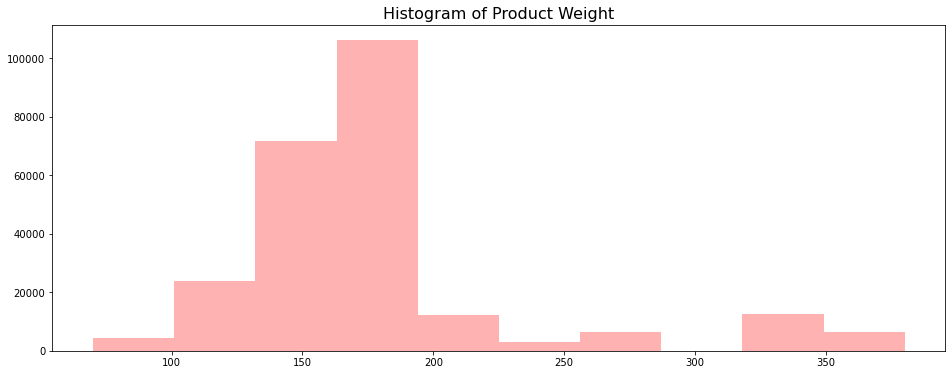

In [47]:
# histogram showing the number of transactions by weight
plt.figure(figsize=(16,6))
plt.hist(comp_df['weight'],color='red',alpha=0.3)
plt.title('Histogram of Product Weight', fontsize=16);

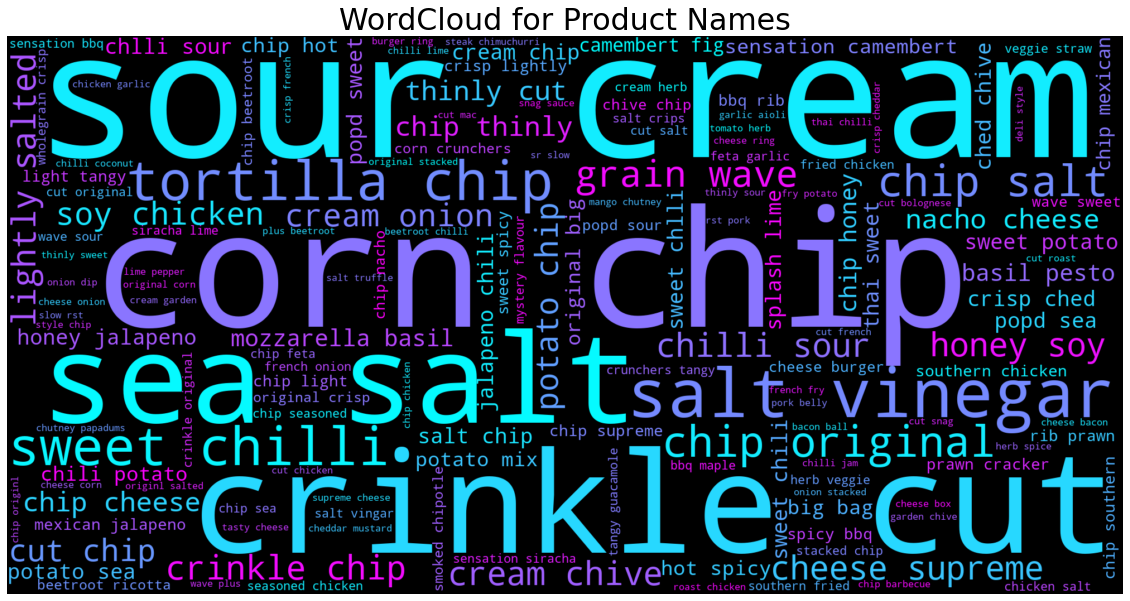

In [48]:
# filter generic & insignificant words such as articles, pronouns, prepositions, and conjunctions 
stop_words = set(stopwords.words('english'))
add_stopwords = ['Cobs','Cheezels','CCs','Cheetos','Doritos','Infuzions','Kettle',
                 'Natural','ChipCo','Pringles','RRD','Smiths','Sunbites','Tyrrells',
                 'Tostitos','Thins','Twisties','WW','Woolworths']  
new_stopwords = []
for i in add_stopwords:
    new_stopwords.append(i.lower())
stop_words.update(new_stopwords)

# Lemmatizing
wordnet = WordNetLemmatizer()

# analyse the reviews for prod_name to check for common flavors of chips in the market
nlp_results = []
for words in comp_df['prod_name']:
    letters = re.sub("[^A-Za-z]", " ",words) # only select words
    tokens = nltk.word_tokenize(letters) # tokenize the product names
    lower_case = [l.lower() for l in tokens] # convert all letters to lower case
    filtered_result = list(filter(lambda l: l not in stop_words,lower_case)) # remove stopwords 
    lemmatized_words=[wordnet.lemmatize(word) for word in filtered_result]
    nlp_results.append(' '.join(lemmatized_words))

words_unique = (" ").join(nlp_results) # create string or bytes-like object
words = words_unique.split()

# TFIDF: bigram
bigramslist = list(nltk.bigrams(words))
bigram = [' '.join(bg) for bg in bigramslist]
vectorizer= TfidfVectorizer(use_idf=True, ngram_range=(2,2))
Z = vectorizer.fit_transform(bigram)
sum_words = Z.sum(axis=0) 
words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)  
words_dict = dict(words_freq)

# Using wordcloud to visualize the comments
wordcloud = WordCloud(width = 2000, height = 1000, background_color='black',colormap='cool').generate_from_frequencies(words_dict)
plt.figure(figsize=(20,12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('WordCloud for Product Names', fontsize=30);

We could notice that the chips with sour cream or sea salt, as well as the corn chip are quite popular among the customers.

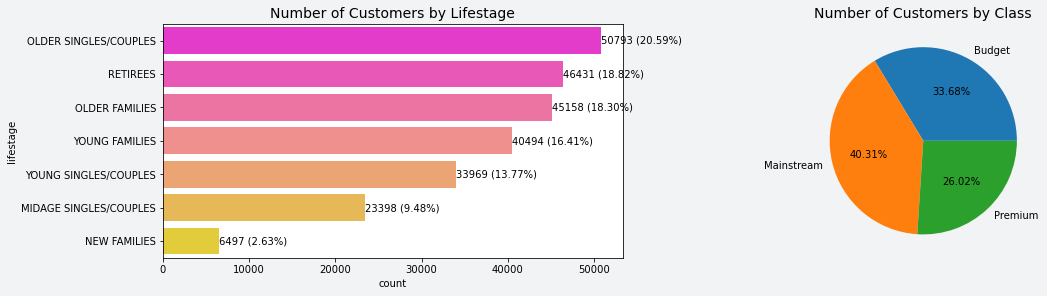

In [49]:
# How many customers are in each segment
fig,ax = plt.subplots(1,2,figsize=(16,4),facecolor='#F2F3F4',constrained_layout=True)
abs_ls = comp_df["lifestage"].value_counts(ascending=False) 
a = sns.countplot(y='lifestage',data=comp_df,palette='spring',order=abs_ls.index, ax=ax[0])
rel_ls = comp_df["lifestage"].value_counts(ascending=False, normalize=True).values*100
lbs_ls = [f"{s[0]} ({s[1]:.2f}%)" for s in zip (abs_ls,rel_ls)]
a.bar_label(a.containers[0], labels=lbs_ls, fontsize=10)
a.set_title('Number of Customers by Lifestage', fontsize=14)

customer_class = comp_df.groupby('premium_customer').agg({'lylty_card_nbr':'nunique'})
customer_class.plot.pie(x='premium_customer',y='lylty_card_nbr',ylabel='',legend=False,autopct='%1.2f%%', ax=ax[1])
ax[1].set_title('Number of Customers by Class', fontsize=14);

In [50]:
customers_counts_sales = comp_df.groupby(['lifestage','premium_customer']).agg({'lylty_card_nbr':'nunique','tot_sales':'sum','prod_qty':'sum','unit_price':'mean'}).rename(columns={'lylty_card_nbr':'num_of_customers'}).reset_index()
customers_counts_sales['unit_price'] = round(customers_counts_sales['unit_price'],2)
customers_counts_sales.sample(3)

lifestage premium_customer  num_of_customers  tot_sales  \
13                RETIREES       Mainstream              6358  145168.95   
1   MIDAGE SINGLES/COUPLES       Mainstream              3298   84734.25   
9    OLDER SINGLES/COUPLES           Budget              4849  127833.60   

    prod_qty  unit_price  
13     37677        3.84  
1      21213        3.99  
9      32883        3.88

C:\Users\NG POOI LING\anaconda3\lib\site-packages\seaborn\categorical.py:381: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

C:\Users\NG POOI LING\anaconda3\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



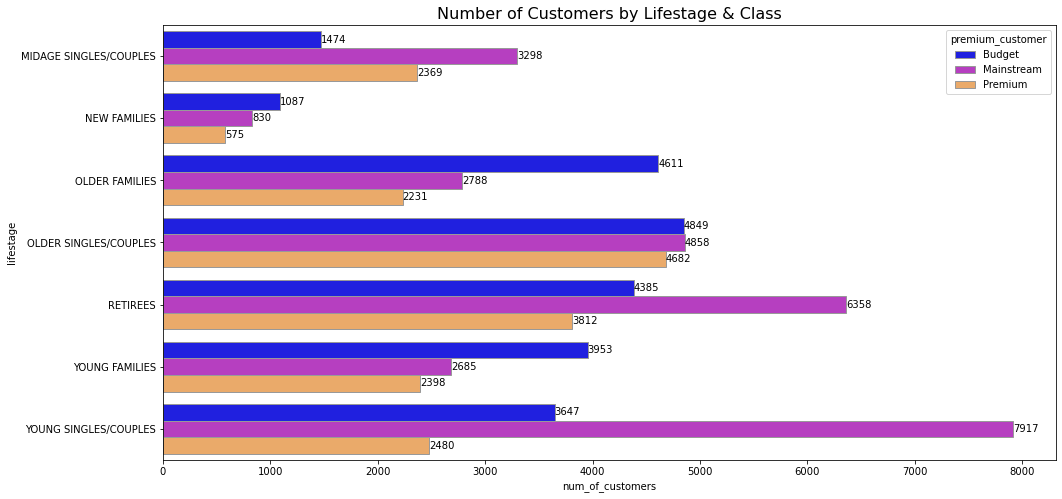

In [51]:
plt.figure(figsize=(16,8))
u = sns.barplot(y='lifestage',x='num_of_customers',hue='premium_customer',
                data=customers_counts_sales,edgecolor=".6",palette='gnuplot2')
u.bar_label(u.containers[0])
u.bar_label(u.containers[1])
u.bar_label(u.containers[2])
plt.title("Number of Customers by Lifestage & Class", fontsize=16);

C:\Users\NG POOI LING\anaconda3\lib\site-packages\seaborn\categorical.py:381: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

C:\Users\NG POOI LING\anaconda3\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



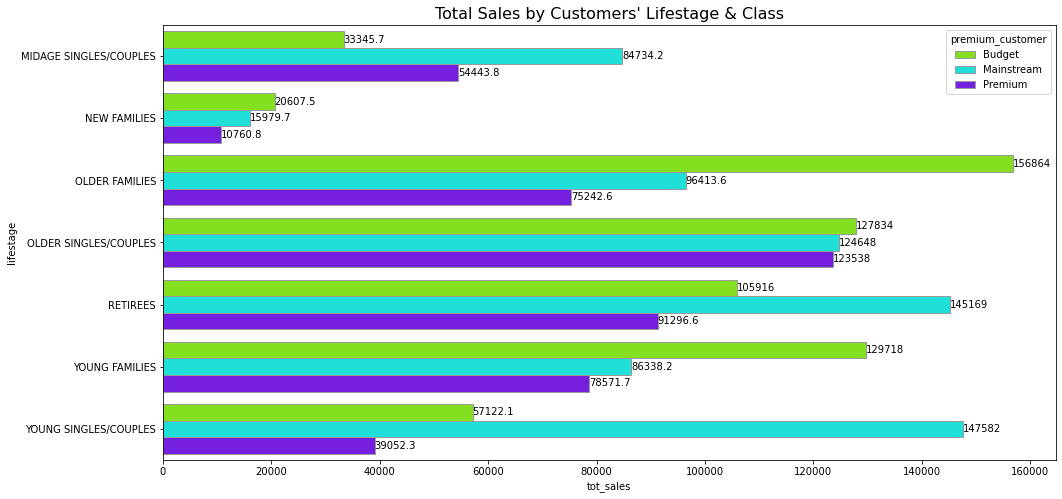

In [52]:
# Who spends the most on chips (total sales), describing customers by lifestage
# how premium their general purchasing behaviour is
plt.figure(figsize=(16,8))
w = sns.barplot(y='lifestage',x='tot_sales',hue='premium_customer',
                data=customers_counts_sales,
                edgecolor=".6",palette='hsv')
w.bar_label(w.containers[0])
w.bar_label(w.containers[1])
w.bar_label(w.containers[2])
plt.title("Total Sales by Customers' Lifestage & Class", fontsize=16);

Sales are coming mainly from Budget - older families, Mainstream - young singles/couples, and Mainstream - retirees.

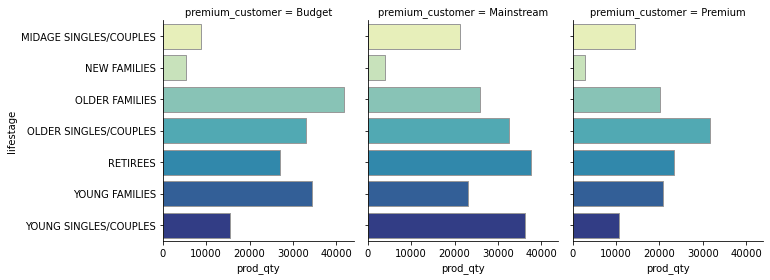

In [53]:
# How many chips are bought per customer by segment
g = sns.catplot(y="lifestage", x="prod_qty",col="premium_customer",
                data=customers_counts_sales, kind="bar",
                height=4, aspect=.9,palette='YlGnBu',edgecolor=".6")

There are more Mainstream - young singles/couples and Mainstream - retirees who buy chips. This contributes to there being more sales to these customer segments but this is not a major driver for the Budget - Older families segment. Higher sales may also be driven by more units of chips being bought per customer. 

C:\Users\NG POOI LING\anaconda3\lib\site-packages\seaborn\categorical.py:381: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

C:\Users\NG POOI LING\anaconda3\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



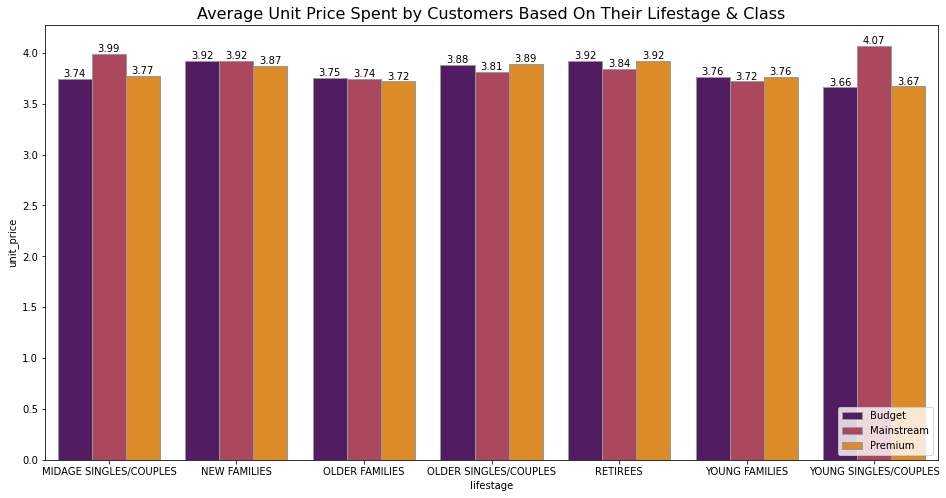

In [54]:
# average chip price by customer segment
plt.figure(figsize=(16,8))
z = sns.barplot(x='lifestage',y='unit_price',hue='premium_customer',
                data=customers_counts_sales,
                edgecolor=".6",palette='inferno')
z.bar_label(z.containers[0])
z.bar_label(z.containers[1])
z.bar_label(z.containers[2])
plt.title("Average Unit Price Spent by Customers Based On Their Lifestage & Class", fontsize=16)
plt.legend(loc='lower right');

C:\Users\NG POOI LING\anaconda3\lib\site-packages\seaborn\categorical.py:381: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

C:\Users\NG POOI LING\anaconda3\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



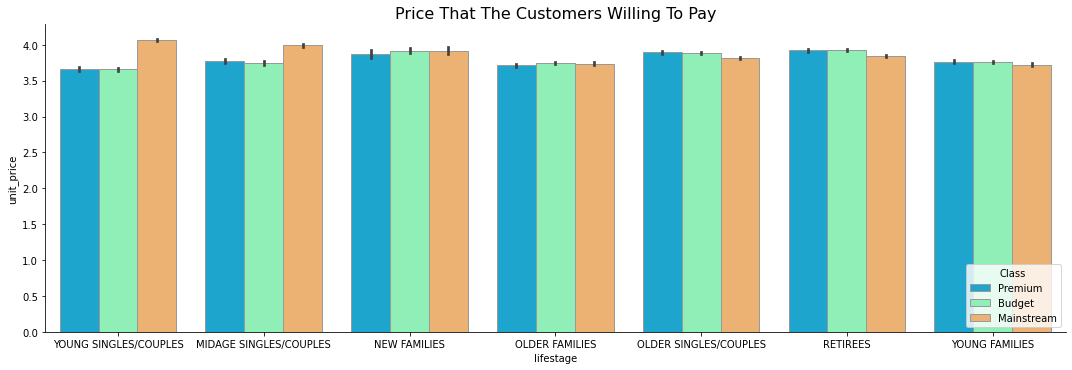

In [55]:
sns.catplot(x="lifestage", y="unit_price", hue="premium_customer", kind="bar", edgecolor=".6", height=5, aspect=3,
            data=comp_df, legend=False, palette='rainbow')
plt.title('Price That The Customers Willing To Pay', fontsize=16)
plt.legend(title="Class",loc='lower right');

In [56]:
if stats.shapiro(comp_df['unit_price'])[1]<0.05:
    print('The distribution of the unit price is normally distributed and we can conduct the z-test.')
else:
    print('The distribution of the unit price is not normally distributed and we cannot conduct the z-test.')

The distribution of the unit price is normally distributed and we can conduct the z-test.


In [57]:
# Perform an independent z-test between mainstream vs premium and budget midage and young singles and couples
mainstream = comp_df[(comp_df['premium_customer']=='Mainstream')&((comp_df['lifestage']=='YOUNG SINGLES/COUPLES')|(comp_df['lifestage']=='MIDAGE SINGLES/COUPLES'))]
not_mainstream = comp_df[(comp_df['premium_customer']!='Mainstream')&((comp_df['lifestage']=='YOUNG SINGLES/COUPLES')|(comp_df['lifestage']=='MIDAGE SINGLES/COUPLES'))]
q,p = ztest(mainstream['unit_price'], not_mainstream['unit_price'])
if p<0.05:
    print('The unit price for mainstream, young and mid-age singles and couples ARE significantly higher than that of budget or premium, young and midage singles and couples.')
else:
    print('The unit price for mainstream, young and mid-age singles and couples ARE NOT significantly higher than that of budget or premium, young and midage singles and couples.')

The unit price for mainstream, young and mid-age singles and couples ARE significantly higher than that of budget or premium, young and midage singles and couples.


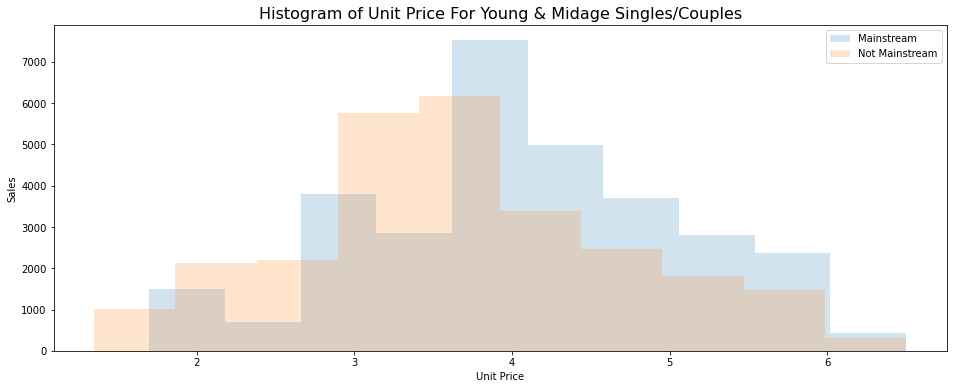

In [58]:
plt.figure(figsize=(16,6))
plt.hist(mainstream.unit_price, alpha=0.2, label='Mainstream')
plt.hist(not_mainstream.unit_price, alpha=0.2, label='Not Mainstream')
plt.title('Histogram of Unit Price For Young & Midage Singles/Couples', fontsize=16)
plt.xlabel('Unit Price')
plt.ylabel('Sales')
plt.legend();

Mainstream midage and young singles and couples are more willing to pay more per packet of chips compared to their budget and premium counterparts. This may be due to premium shoppers being more likely to buy healthy snacks and when they buy chips, this is mainly for entertainment purposes rather than their own consumption. This is also supported by there being fewer premium midage and young singles and couples buying chips compared to their mainstream counterparts.

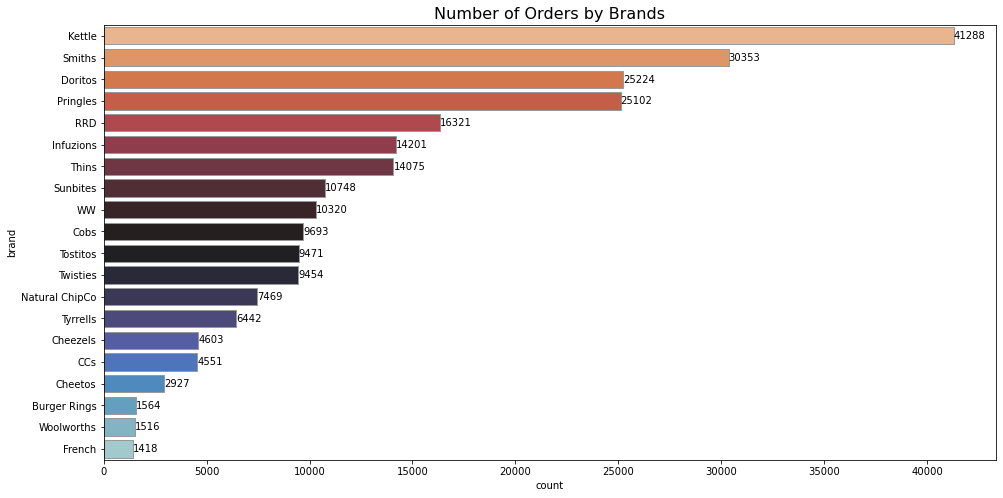

In [59]:
plt.figure(figsize=(16,8))
v = sns.countplot(y=comp_df['brand'],palette='icefire_r',
                  order=comp_df['brand'].value_counts().index,edgecolor=".6")
v.bar_label(v.containers[0])
plt.title('Number of Orders by Brands', fontsize=16);

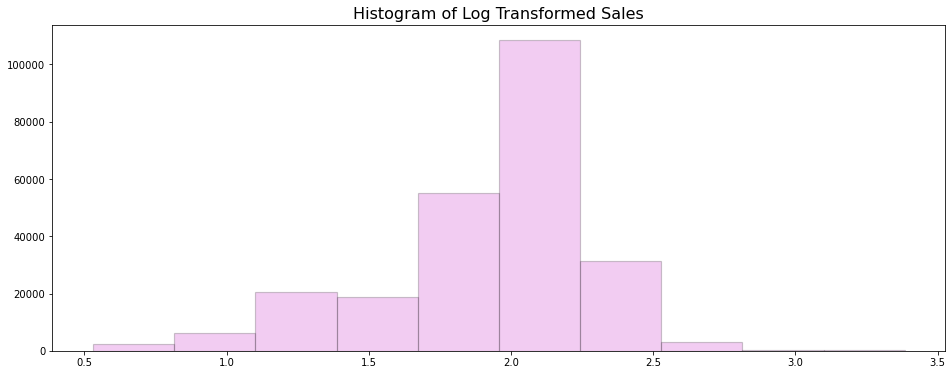

In [60]:
plt.figure(figsize=(16,6))
plt.hist(np.log(comp_df.tot_sales),color='m',alpha=0.2,edgecolor='black', linewidth=1.2)
plt.title('Histogram of Log Transformed Sales', fontsize=16);

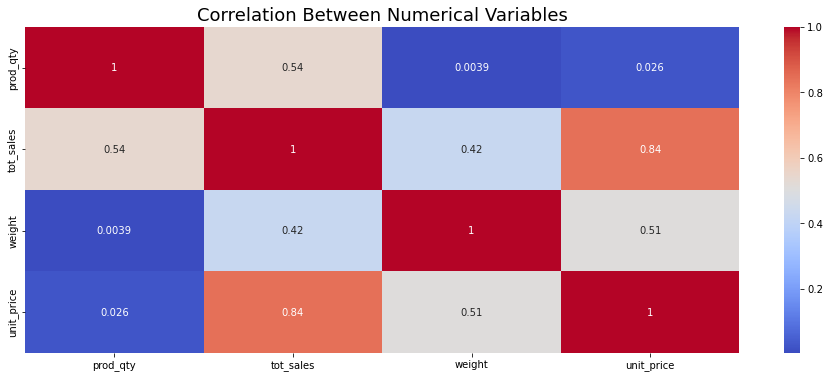

In [61]:
plt.figure(figsize=(16,6))
sns.heatmap(comp_df[['prod_qty','tot_sales','weight','unit_price']].corr(),annot=True,fmt='.2g',cmap='coolwarm')
plt.title('Correlation Between Numerical Variables',fontsize=18);

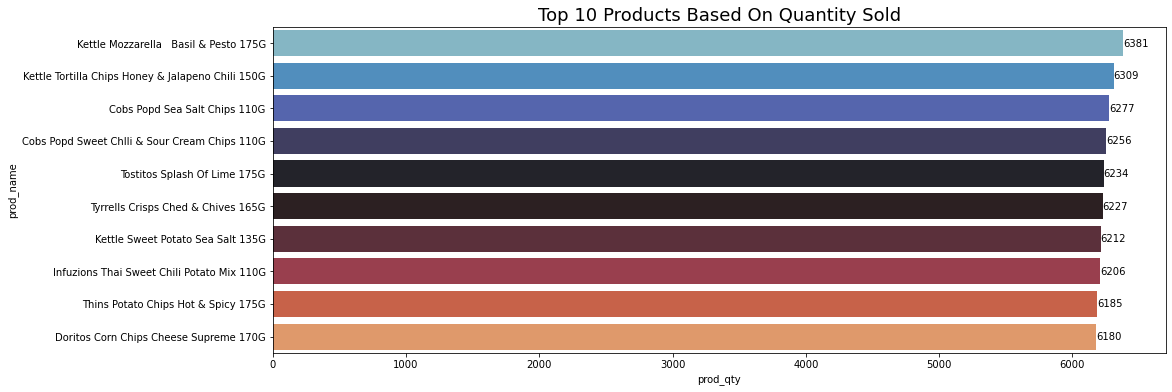

In [62]:
# top 10 products based on quantity sold
plt.figure(figsize=(16,6))
top_prod_by_qty = comp_df.groupby('prod_name').agg({'prod_qty':'sum'}).sort_values('prod_qty',ascending=False).head(10)
t = sns.barplot(y=top_prod_by_qty.index, x='prod_qty',data=top_prod_by_qty, palette='icefire')
t.bar_label(t.containers[0])
plt.title('Top 10 Products Based On Quantity Sold',fontsize=18);

# Summary 
1. Most of the brands from the datasets are from <a href="https://smiths.com.au/#">The Smith's Snackfood Company Pty Ltd</a>.
2. We could notice that the chips with sour cream or sea salt, as well as the corn chip are quite popular among the customers.
3. Mainstream midage and young singles and couples are more willing to pay more per packet of chips compared to their budget and premium counterparts. 
4. There are more Mainstream - young singles/couples and Mainstream - retirees who buy chips. This contributes to there being more sales to these customer segments but this is not a major driver for the Budget - Older families segment. Higher sales may also be driven by more units of chips being bought per customer.
5. Sales are coming mainly from Budget - older families, Mainstream - young singles/couples, and Mainstream - retirees.